The goal is to predict the next week's deaths from COVID-19 for a region.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import missingno 
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from math import sqrt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

## Loading datasets 

In [2]:
train_dataset_path = '/Users/macbook/Documents/DataScience/Projects/Covid19-Death-Predictions/train.csv'
test_dataset_path = '/Users/macbook/Documents/DataScience/Projects/Covid19-Death-Predictions/test.csv'
submission_path = '/Users/macbook/Documents/DataScience/Projects/Covid19-Death-Predictions/sample_submission.csv'

In [3]:
train_df = pd.read_csv(train_dataset_path, sep = ',')
test_df = pd.read_csv(test_dataset_path, sep = ',')

## EDA

In [4]:
train_df.head()

,Id,Location,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Total Vaccinations,People Vaccinated,People Fully Vaccinated,Total Boosters,Daily Vaccinations,Total Vaccinations per Hundred,People Vaccinated per Hundred,People Fully Vaccinated per Hundred,Total Boosters per Hundred,Daily Vaccinations per Hundred,Daily People Vaccinated,Daily People Vaccinated per Hundred,Next Week's Deaths
0,911530868,World,2372.0,2020,0.300,65.0,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,344.0
1,807936902,World,5023.0,2020,0.635,114.0,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361.0
2,773590408,World,5612.0,2020,0.710,116.0,0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431.0
3,130466459,World,7580.0,2020,0.958,153.0,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0
4,544040446,World,8983.0,2020,1.136,187.0,0.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.0


In [5]:
train_df.describe()

,Id,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Total Vaccinations,People Vaccinated,People Fully Vaccinated,Total Boosters,Daily Vaccinations,Total Vaccinations per Hundred,People Vaccinated per Hundred,People Fully Vaccinated per Hundred,Total Boosters per Hundred,Daily Vaccinations per Hundred,Daily People Vaccinated,Daily People Vaccinated per Hundred,Next Week's Deaths
count,1.291560e+05,1.289430e+05,129156.000000,128288.000000,127898.000000,127247.000000,4.027000e+04,3.842900e+04,3.657400e+04,1.984700e+04,7.784000e+04,40270.000000,38429.000000,36574.000000,19847.000000,77840.000000,7.739100e+04,77391.000000,129156.000000
mean,5.502597e+08,9.520131e+04,2020.912919,1379.071563,1072.815494,10.845384,2.450093e+08,1.174096e+08,9.862264e+07,4.365458e+07,4.742138e+05,89.723652,43.424276,38.421866,20.160324,2702.988798,1.823430e+05,0.114669,1064.082776
std,2.599890e+08,6.329716e+05,0.739667,4013.421702,5287.848128,24.740908,1.032824e+09,4.932070e+08,4.303844e+08,1.862997e+08,2.593336e+06,74.209648,30.074617,29.197973,22.598973,3468.942102,1.061855e+06,0.202150,5251.447471
min,1.000006e+08,0.000000e+00,2020.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,3.253421e+08,1.040000e+02,2020.000000,18.291500,1.000000,0.050000,9.900038e+05,5.771390e+05,4.683338e+05,3.894150e+04,1.065000e+03,18.730000,12.810000,8.390000,0.295000,402.000000,3.280000e+02,0.012000,1.000000
50%,5.497285e+08,1.084000e+03,2021.000000,188.584000,13.000000,1.709000,7.772026e+06,4.306986e+06,3.811594e+06,1.397130e+06,9.182500e+03,79.195000,46.330000,38.515000,9.780000,1498.000000,3.287000e+03,0.046000,13.000000
75%,7.756598e+08,9.750000e+03,2021.000000,1046.367750,127.000000,10.934000,4.976308e+07,2.557442e+07,2.168825e+07,1.114840e+07,6.394475e+04,146.290000,70.380000,64.720000,36.860000,3840.000000,2.318000e+04,0.141000,125.000000
max,9.999993e+08,2.406618e+07,2022.000000,104220.239000,103568.000000,1040.710000,1.212140e+10,5.255161e+09,4.816606e+09,2.129044e+09,4.368841e+07,366.870000,128.780000,126.790000,125.850000,117862.000000,2.099974e+07,11.786000,102123.000000


In [6]:
train_df.isna().sum()

Id                                          0
Location                                    0
Weekly Cases                              213
Year                                        0
Weekly Cases per Million                  868
Weekly Deaths                            1258
Weekly Deaths per Million                1909
Total Vaccinations                      88886
People Vaccinated                       90727
People Fully Vaccinated                 92582
Total Boosters                         109309
Daily Vaccinations                      51316
Total Vaccinations per Hundred          88886
People Vaccinated per Hundred           90727
People Fully Vaccinated per Hundred     92582
Total Boosters per Hundred             109309
Daily Vaccinations per Hundred          51316
Daily People Vaccinated                 51765
Daily People Vaccinated per Hundred     51765
Next Week's Deaths                          0
dtype: int64

<AxesSubplot:>

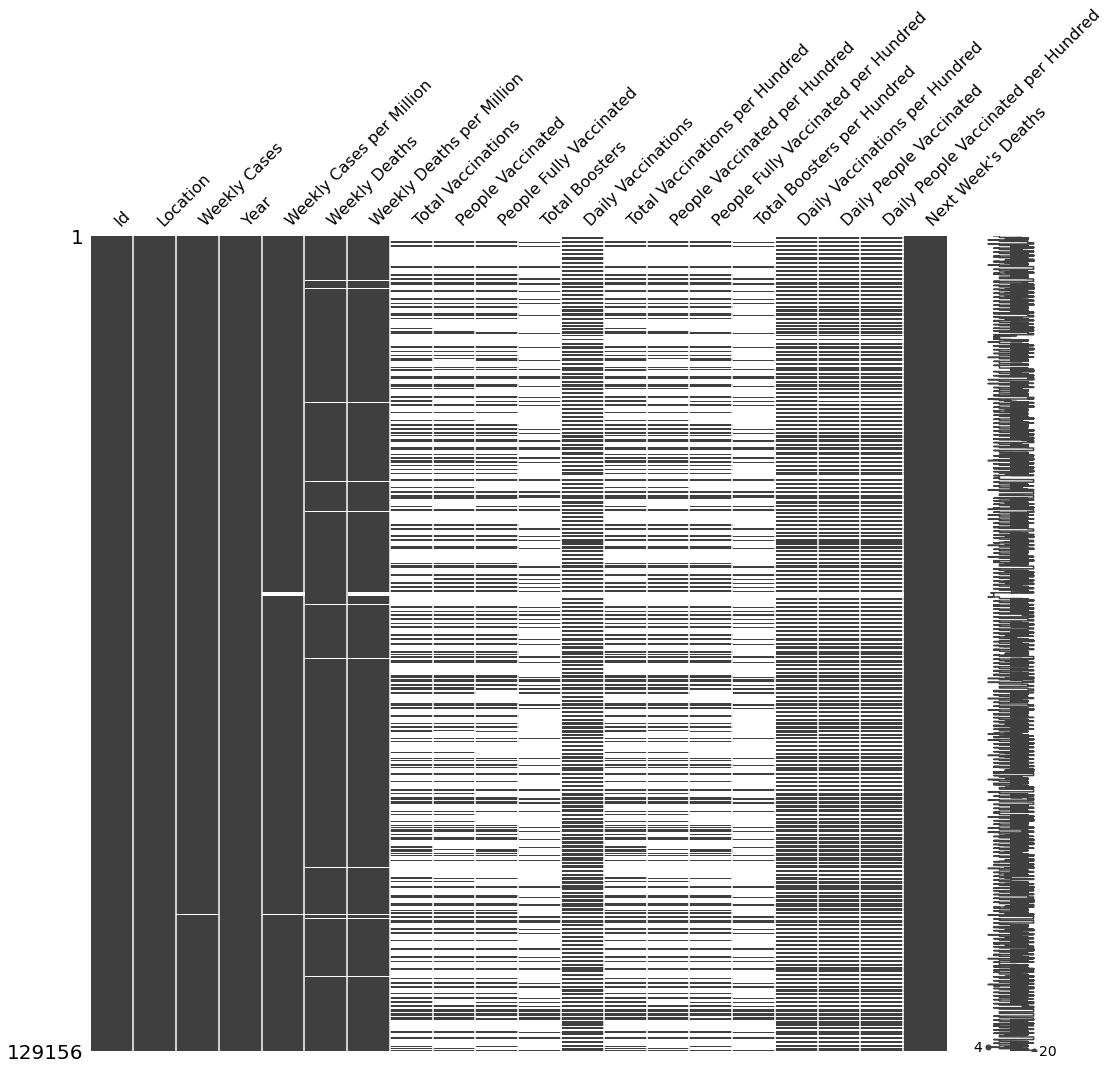

In [7]:
missingno.matrix(train_df.sort_values(by=['Location', 'Year']), figsize = (17,15))

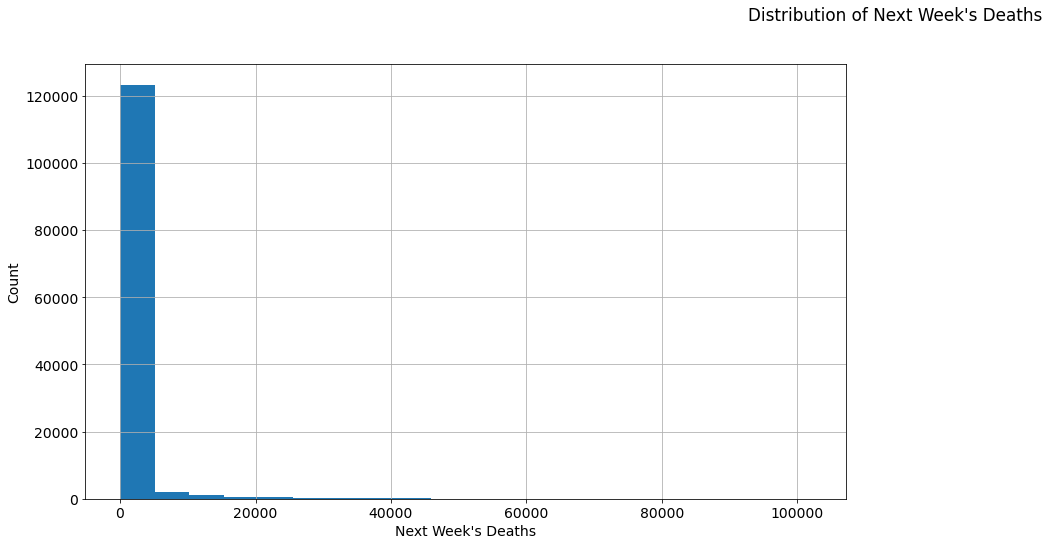

In [8]:
plt.figure(figsize = (30, 8))

plt.subplot(121)
train_df['Next Week\'s Deaths'].hist(density=False, bins=20)
plt.ylabel('Count')
plt.xlabel('Next Week\'s Deaths')

plt.suptitle('Distribution of Next Week\'s Deaths')
plt.show()

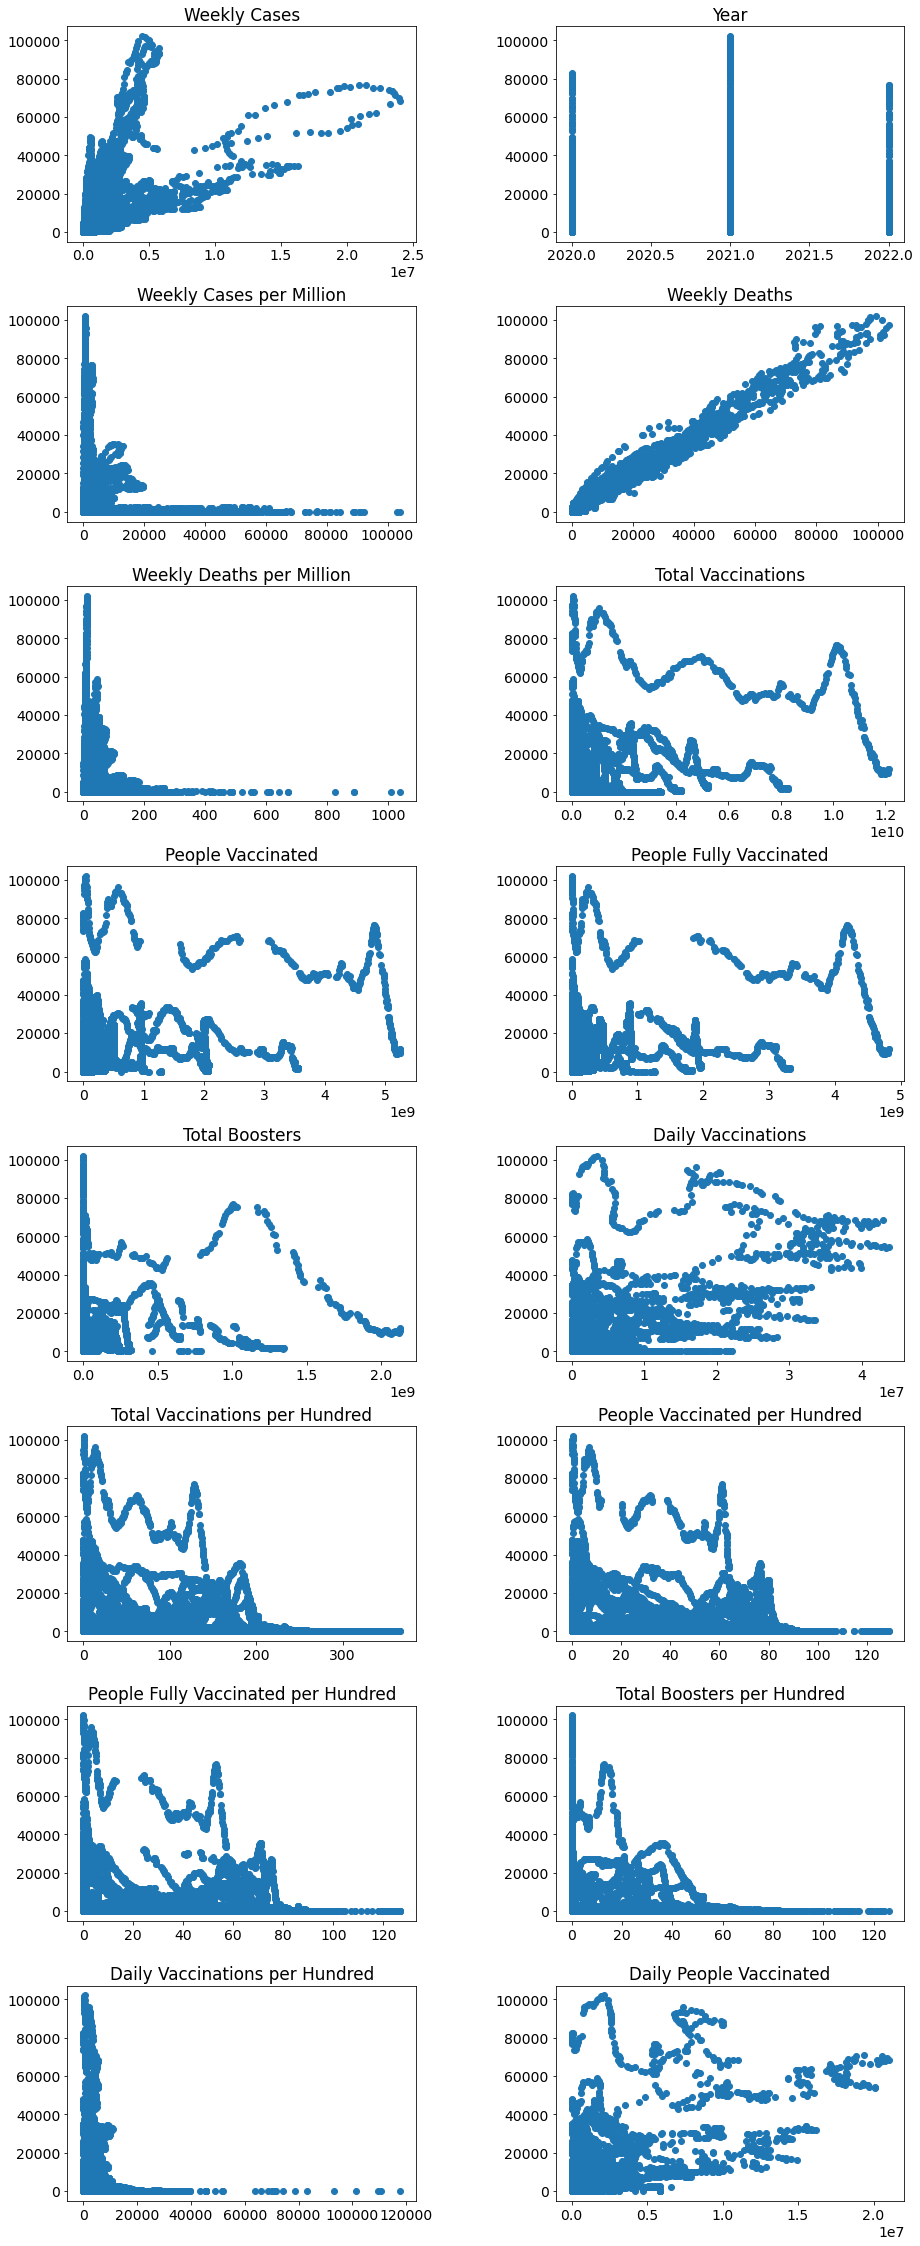

In [9]:
fig, ax = plt.subplots(nrows=8, ncols=2)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16 = ax.flatten()
g = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]
fig.set_size_inches(15, 40)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

for f, g in zip(train_df.columns[2:18], g):
    g.scatter(train_df[f], train_df['Next Week\'s Deaths'])
    g.set_title(f)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129156 entries, 0 to 129155
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Id                                   129156 non-null  int64  
 1   Location                             129156 non-null  object 
 2   Weekly Cases                         128943 non-null  float64
 3   Year                                 129156 non-null  int64  
 4   Weekly Cases per Million             128288 non-null  float64
 5   Weekly Deaths                        127898 non-null  float64
 6   Weekly Deaths per Million            127247 non-null  float64
 7   Total Vaccinations                   40270 non-null   float64
 8   People Vaccinated                    38429 non-null   float64
 9   People Fully Vaccinated              36574 non-null   float64
 10  Total Boosters                       19847 non-null   float64
 11  Daily Vaccina

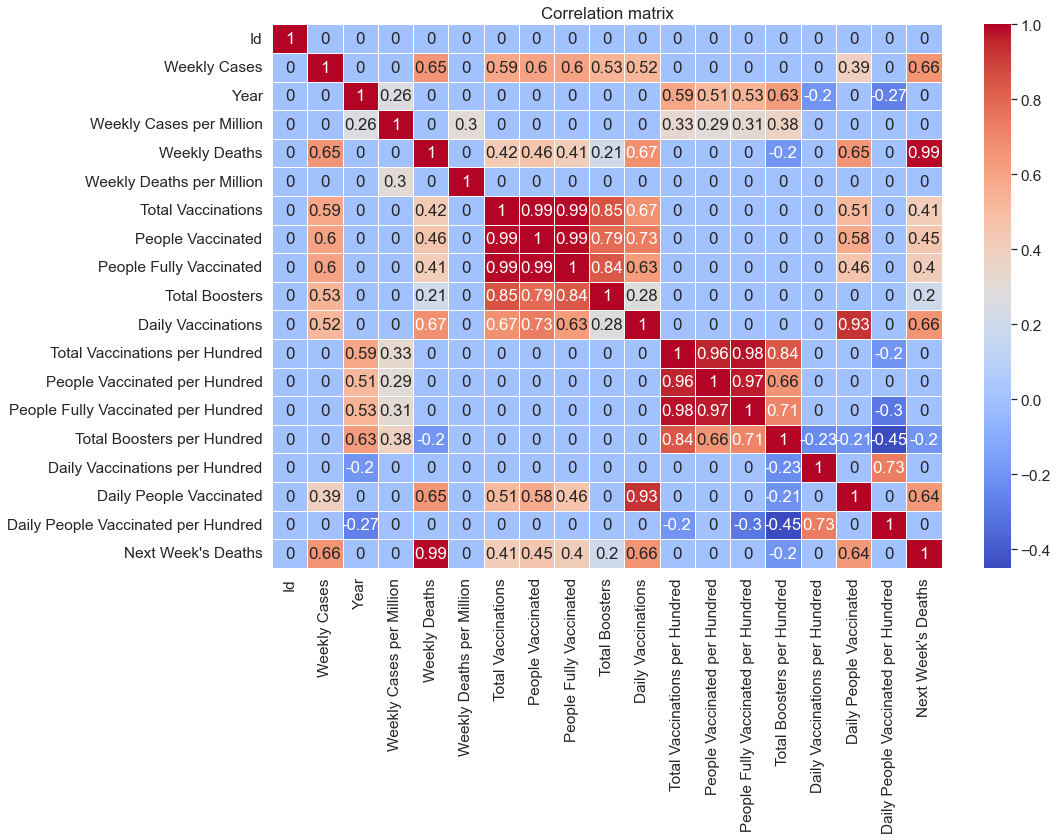

In [11]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

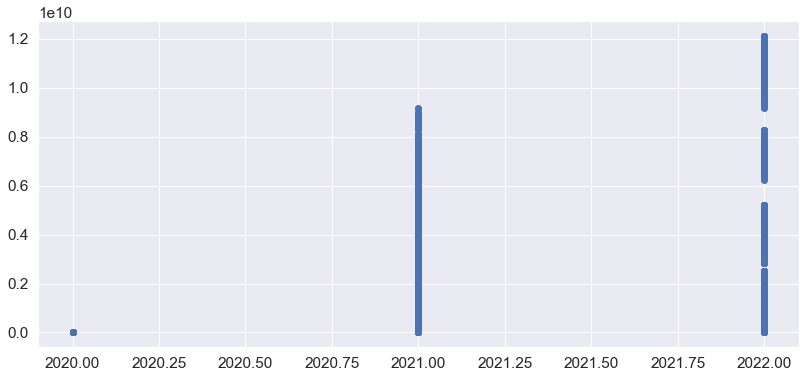

In [12]:
plt.figure(figsize = (30, 6))
plt.subplot(121)
plt.scatter(train_df['Year'], train_df['Total Vaccinations'])
plt.show()

In [13]:
train_df.loc[train_df['Total Vaccinations'].isna(), 'Year'].value_counts()

2020    41151
2021    29997
2022    17738
Name: Year, dtype: int64

- We have a lot of missing values and two categorical variables ('Year', 'Location'), one of which needs to be encoded ('Location').

- 'Total Boosters', 'Total Boosters per Hundred' have too much missing values so it would be better to ignore them at all.

- Features related to vaccination prevalence also have Nan values. Since the first vaccines were authorized at the end of 2020 it is best to fill in missing values for 2020 with zeroes. For other years, it would be logical to fill in the missing values with the avearages of the features grouped by location and year.

## Data preprocessing

In [14]:
class DataPreparation():

    def __init__(self):
        
        self.feature_names = ['Weekly Cases', 'Weekly Deaths', 'Weekly Cases per Million',
                            'Weekly Deaths per Million', 'People Vaccinated','Total Vaccinations',
                            'People Fully Vaccinated','Daily Vaccinations','Total Vaccinations per Hundred',
                            'People Vaccinated per Hundred','People Fully Vaccinated per Hundred',
                            'Daily Vaccinations per Hundred','Daily People Vaccinated',
                            'Daily People Vaccinated per Hundred']
        
        self.encoder = TargetEncoder(smoothing=1.5)
    
    def fit(self, df):
        
        self.encoder.fit(df['Location'], df['Next Week\'s Deaths'])
        
    def transform(self, df):
        
        df = df.drop(['Id', 'Total Boosters', 'Total Boosters per Hundred'], axis=1)
        
        for feature in self.feature_names[4:]:
            df.loc[(df[feature].isna()) & (df['Year'] == 2020), feature] = 0
        

        for feature in self.feature_names:
            df[feature] = df[feature].fillna(df.groupby(['Location', 'Year'])[feature].transform(np.nanmean))
            df[feature] = df[feature].fillna(0)
            
        df['loc_encoded'] = self.encoder.transform(df['Location'])
        df = df.drop('Location', axis=1)
        
        return df

In [15]:
preprocessor = DataPreparation()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

## Cat Boost Regressor

In [16]:
y = train_df['Next Week\'s Deaths']

In [17]:
X = train_df.drop('Next Week\'s Deaths', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state = 42)

In [18]:
cb = CatBoostRegressor(silent=True,
                        max_depth=14,
                        random_state=42,
                        iterations=1200)

cb.fit(X_train, y_train)
train_pred = cb.predict(X_train)
valid_pred = cb.predict(X_valid)

In [19]:
print(sqrt(mse(y_train, train_pred)))
print(sqrt(mse(y_valid, valid_pred)))

91.17214400844257
267.3934096575452


## Prediction

In [20]:
predictions = cb.predict(test_df)
submission = pd.read_csv(submission_path, sep=',')
submission.head()

,Id,Next Week's Deaths
0,719557359,0
1,507527289,0
2,821551528,0
3,696602016,0
4,680387432,0


In [21]:
submission['Next Week\'s Deaths'] = predictions
submission.head()

,Id,Next Week's Deaths
0,719557359,-0.306617
1,507527289,-4.257339
2,821551528,-6.134734
3,696602016,-3.348154
4,680387432,2.246519


In [22]:
submission.to_csv('cb_submit*.csv', index=False)